# Object detection demo
This notebook shows an example of object detection of an image.
The network that is used for inference is a variant of Tiny-Yolo, whose topology is illustrated in the following picture.
The pynq colored layers have been quantized with 1 bit for weights and 3 bit for activations, and will be executed in the HW accelerator, while the other layers are executed in python.

The image processing is performed within darknet by using python bindings.


![TinierYolo topology](Tinier-YOLO-topology.svg)

In [6]:
import sys
import os, platform
import json
import numpy as np
import cv2
import ctypes

from PIL import Image
from datetime import datetime


import qnn
from qnn import TinierYolo
from qnn import utils 
sys.path.append("/opt/darknet/python/")
from darknet import *

from matplotlib import pyplot as plt
%matplotlib inline

## 1. Instantiate a Classifier
Creating a classifier will automatically download the bitstream onto the device. All other initializations are currently performed in the Darknet framework. 

In [7]:
classifier = TinierYolo()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-W.npy', encoding="latin1")
conv0_weights_correct = np.transpose(conv0_weights, axes=(3, 2, 1, 0))
conv8_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-W.npy', encoding="latin1")
conv8_weights_correct = np.transpose(conv8_weights, axes=(3, 2, 1, 0))
conv0_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-bias.npy', encoding="latin1")
conv0_bias_broadcast = np.broadcast_to(conv0_bias[:,np.newaxis], (net['conv1']['input'][0],net['conv1']['input'][1]*net['conv1']['input'][1]))
conv8_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-bias.npy', encoding="latin1")
conv8_bias_broadcast = np.broadcast_to(conv8_bias[:,np.newaxis], (125,13*13))
file_name_cfg = c_char_p("/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-bwn-3bit-relu-nomaxpool.cfg".encode())

net_darknet = lib.parse_network_cfg(file_name_cfg)

## 2. Get object detection from input image


The image to be run through object detection is loaded automatically from the path set in the *img_folder* variable. The original image is shown before processing and will be automatically selected as the last one downloaded (both variables *img_folder* and *image_name* can be modified to the desired path/image to be classified). 

The neural network has been trained on the [PASCAL VOC (Visual Object Classes)](http://host.robots.ox.ac.uk/pascal/VOC/) and is able to identify 20 classes of objects in an image, namely: 
* Person: person
* Animal: bird, cat, cow, dog, horse, sheep
* Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
* Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

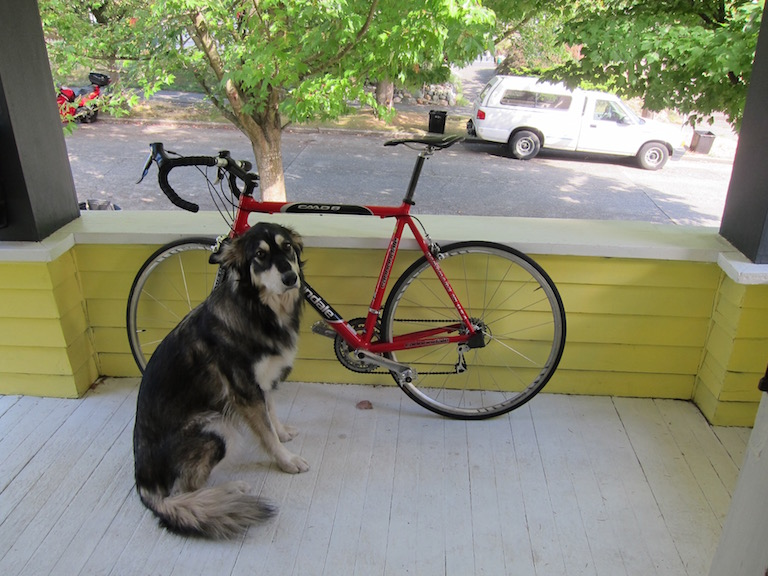

In [15]:
img_folder = './yoloimages/'
img_file = os.path.join(img_folder, random.choice(os.listdir(img_folder)))
file_name = c_char_p(img_file.encode())

img = load_image(file_name,0,0)
img_letterbox = letterbox_image(img,416,416)
img_copy = np.copy(np.ctypeslib.as_array(img_letterbox.data, (3,416,416)))
img_copy = np.swapaxes(img_copy, 0,2)
free_image(img)
free_image(img_letterbox)

im = Image.open(img_file)
im

## 3. Execute the first convolutional layer in Python

The first layer of this neural network has not been quantized, thus will not be executed in the HW accelerator (which supports only quantized arithmetic). Python provides, with numpy, a backend to execute convolution and other matrix operations. For user convenience the most popular operations (convolutional layer, thresholding, relu and fully connected layer) are provided in the utils class.

In [16]:
start = datetime.now()
img_copy = img_copy[np.newaxis, :, :, :]
    
conv0_ouput = utils.conv_layer(img_copy,conv0_weights_correct,b=conv0_bias_broadcast,stride=2,padding=1)
conv0_output_quant = conv0_ouput.clip(0.0,4.0)
conv0_output_quant = utils.quantize(conv0_output_quant/4,3)
end = datetime.now()
micros = int((end - start).total_seconds() * 1000000)
print("First layer SW implementation took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'w'))

First layer SW implementation took 261091 microseconds


## 4. HW Offload of the quantized layers

The core layers, which values have been quantized during training, are executed in the Programmable Logic. The hardware accelerator consists of a dataflow implementation of multiple layers (in this case, convolution+maxpool). The host code parses the network topology (specified in the json file) and manages the sequence of execution on the accelerator.

In [17]:
out_dim = net['conv7']['output'][1]
out_ch = net['conv7']['output'][0]

conv_output = classifier.get_accel_buffer(out_ch, out_dim)
conv_input = classifier.prepare_buffer(conv0_output_quant*7);

start = datetime.now()
classifier.inference(conv_input, conv_output)
end = datetime.now()

conv7_out = classifier.postprocess_buffer(conv_output)

micros = int((end - start).total_seconds() * 1000000)
print("HW implementation took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'a'))

HW implementation took 106098 microseconds


## 5. Execute the last convolutional layer in Python

In [18]:
start = datetime.now()
conv7_out_reshaped = conv7_out.reshape(out_dim,out_dim,out_ch)
conv7_out_swapped = np.swapaxes(conv7_out_reshaped, 0, 1) # exp 1
conv7_out_swapped = conv7_out_swapped[np.newaxis, :, :, :] 

conv8_output = utils.conv_layer(conv7_out_swapped,conv8_weights_correct,b=conv8_bias_broadcast,stride=1)  
conv8_out = conv8_output.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

end = datetime.now()
micros = int((end - start).total_seconds() * 1000000)
print("Last layer SW implementation took {} microseconds".format(micros))
print(micros, file=open('timestamp.txt', 'a'))

Last layer SW implementation took 48756 microseconds


## 6. Draw detection boxes using Darknet

The image postprocessing (drawing the bounding boxes) is performed in darknet using python bindings.

In [19]:
lib.forward_region_layer_pointer_nolayer(net_darknet,conv8_out)
tresh = c_float(0.3)
tresh_hier = c_float(0.5)
file_name_out = c_char_p("/home/xilinx/jupyter_notebooks/qnn/detection".encode())
file_name_probs = c_char_p("/home/xilinx/jupyter_notebooks/qnn/probabilities.txt".encode())
file_names_voc = c_char_p("/opt/darknet/data/voc.names".encode())
darknet_path = c_char_p("/opt/darknet/".encode())
lib.draw_detection_python(net_darknet, file_name, tresh, tresh_hier,file_names_voc, darknet_path, file_name_out, file_name_probs);

#Print probabilities
file_content = open(file_name_probs.value,"r").read().splitlines()
detections = []
for line in file_content[0:]:
    name, probability = line.split(": ")
    detections.append((probability, name))
for det in sorted(detections, key=lambda tup: tup[0], reverse=True):
    print("class: {}\tprobability: {}".format(det[1], det[0]))

class: car	probability: 86%
class: dog	probability: 86%
class: bicycle	probability: 78%


## 7. Show the result

The classified image is shown in the notebook. The bounding boxes are drawn on top of the original image, showing the detected objects and their position.

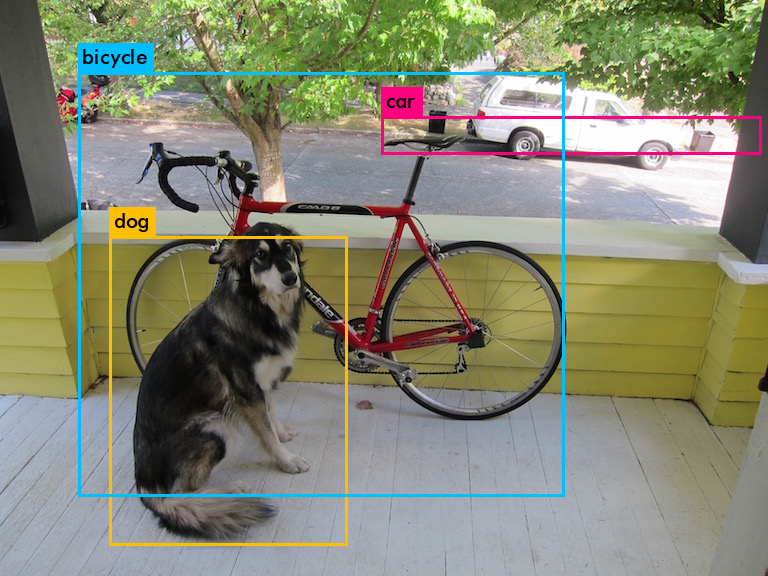

In [20]:
res = Image.open(file_name_out.value.decode() + ".png")
res

## 8. Performance analysis

The execution in mixed SW-HW design is profiled, and the performances in terms of latency and throughput are analysed and shown in the graph

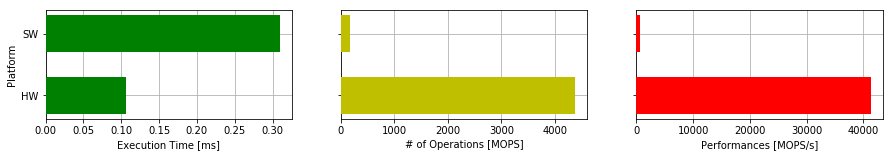

In [21]:
array = np.loadtxt('timestamp.txt')
array = list(map(lambda x: x/1000000, array))

MOPS=[171.3254,4385.99]
TIME=[array[0]+array[2],array[1]]
LABELS=["SW", "HW"]

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))

plt.yticks(x_pos, LABELS)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time [ms]")
ax1.set_ylabel("Platform")
ax1.barh(x_pos, TIME, height=0.6, color='g', zorder=3)
ax1.grid(zorder=0)

ax2.invert_yaxis()
ax2.set_xlabel("# of Operations [MOPS]")
ax2.barh(x_pos, MOPS, height=0.6, color='y', zorder=3)
ax2.grid(zorder=0)

MOPSS=[MOPS[i]/TIME[i] for i in range(len(MOPS))]
x_pos = np.arange(len(LABELS))
ax3.barh(x_pos, MOPSS, height=0.6, color='r', zorder=3)
ax3.invert_yaxis()
ax3.set_xlabel("Performances [MOPS/s]")
ax3.grid(zorder=0)
plt.show()

## Reset the device

In [22]:
classifier.deinit_accelerator()

In [23]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()